In [1]:
import math
import time
from tortreinador.utils.metrics import r2_score
import numpy as np
import torch
import torch.nn as nn
from tortreinador.models.MDN import mdn as mdn_advance, Mixture, NLLLoss
from tortreinador.utils.View import init_weights
import matplotlib.pyplot as plt
import proplot as pplt
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import joblib
from sklearn.preprocessing import StandardScaler


In [2]:
input_parameters = [
    'Mass (M_J)',
    'Radius (R_E)',
    'T_sur (K)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

In [3]:
test_x = np.load("D:\\Resource\\MDN\\TestData\\GasGiantExo\\test_x.npy")
test_y = np.load("D:\\Resource\\MDN\\TestData\\GasGiantExo\\test_y.npy")

In [4]:
model = mdn_advance(len(input_parameters), len(output_parameters), 20, 512)
init_weights(model)
model = nn.DataParallel(model)
model.to("cuda")
model.load_state_dict(torch.load("D:\\Resource\\MDN\\GrainExoModel\\best_model.pth"))

<All keys matched successfully>

In [5]:
model.eval()
# Predict
pi, mu, sigma = model(torch.from_numpy(test_x))

In [6]:
mix = Mixture()
criterion = NLLLoss()
mse = nn.MSELoss()
sample = mix(pi, mu, sigma).sample()
t_y = torch.from_numpy(test_y).to('cuda')
print("NLLLoss: {}, MSE: {}, R2: {}".format(criterion(pi, mu, sigma, t_y),
                                            mse(t_y, sample),
                                            r2_score(sample, t_y)))

NLLLoss: -20.235792974056668, MSE: 0.0005294011582607661, R2: 0.9853390964732902


In [7]:
m_y = joblib.load("D:\\Resource\\MDN\\TestData\\GasGiantExo\\MDN_v3_yscaler_20231201.save")

In [10]:
def calculate_GMM(p, m, s):
    y_label = np.arange(0,1,0.01).reshape(-1,1)
    y_label_ = y_label[:, np.newaxis, np.newaxis, :]
    
    mu_sub_T = np.transpose(m, (0, 2, 1))
    sigma_sub_T = np.transpose(s, (0, 2, 1))
    
    # shape(1000, 6, 100, 10) 1000 data, 6 type, 100 rows with 10 columns every type
    exponent = np.exp(-1/2*np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3))/sigma_sub_T[:, :, np.newaxis, :]))
    factors = 1 / math.sqrt(2*math.pi) / sigma_sub_T[:, :, np.newaxis, :]
    GMM_PDF = np.sum(p[:, np.newaxis, np.newaxis, :]*factors*exponent, axis=-1)
    MM = MinMaxScaler()
    GMM_PDF = GMM_PDF.reshape(GMM_PDF.shape[0] * GMM_PDF.shape[1], GMM_PDF.shape[-1]).transpose((-1, 0))
    # f = e.transpose((-1, 0))
    return MM.fit_transform(GMM_PDF)

In [8]:
pi_exp = torch.exp(pi)
mu_np = mu.detach().cpu().numpy()
sigma_np = sigma.detach().cpu().numpy()
pi_np = pi_exp.detach().cpu().numpy()

In [11]:
GMM_scaled = calculate_GMM(pi_np, mu_np, sigma_np)

In [13]:
test_y_inverse = m_y.inverse_transform(test_y)

In [15]:
col_dis = []
for o in range(len(output_parameters)):
    y_max = max(test_y_inverse[:, o])
    y_min = min(test_y_inverse[:, o])
    mean_dis = 0
    for i in range(0, GMM_scaled.shape[-1], len(output_parameters)):
        tx, ty = [test_y_inverse[int(i / len(output_parameters)), o], y_min]
        GMM_cal = GMM_scaled[:, o + i].reshape(-1, 1)
        dis = np.abs(np.mean(GMM_cal - tx) / np.sqrt(2))
        mean_dis += dis

    col_dis.append(mean_dis / len(test_y_inverse))
m_s = StandardScaler()
m_s.fit_transform(np.array(col_dis).reshape(-1, 1))

array([[-0.58297868],
       [-0.57353167],
       [-0.57552972],
       [ 1.73204007]])

In [16]:
col_dis

[234.2610337458644, 753.4321858469895, 643.6270246131068, 127458.68057610527]

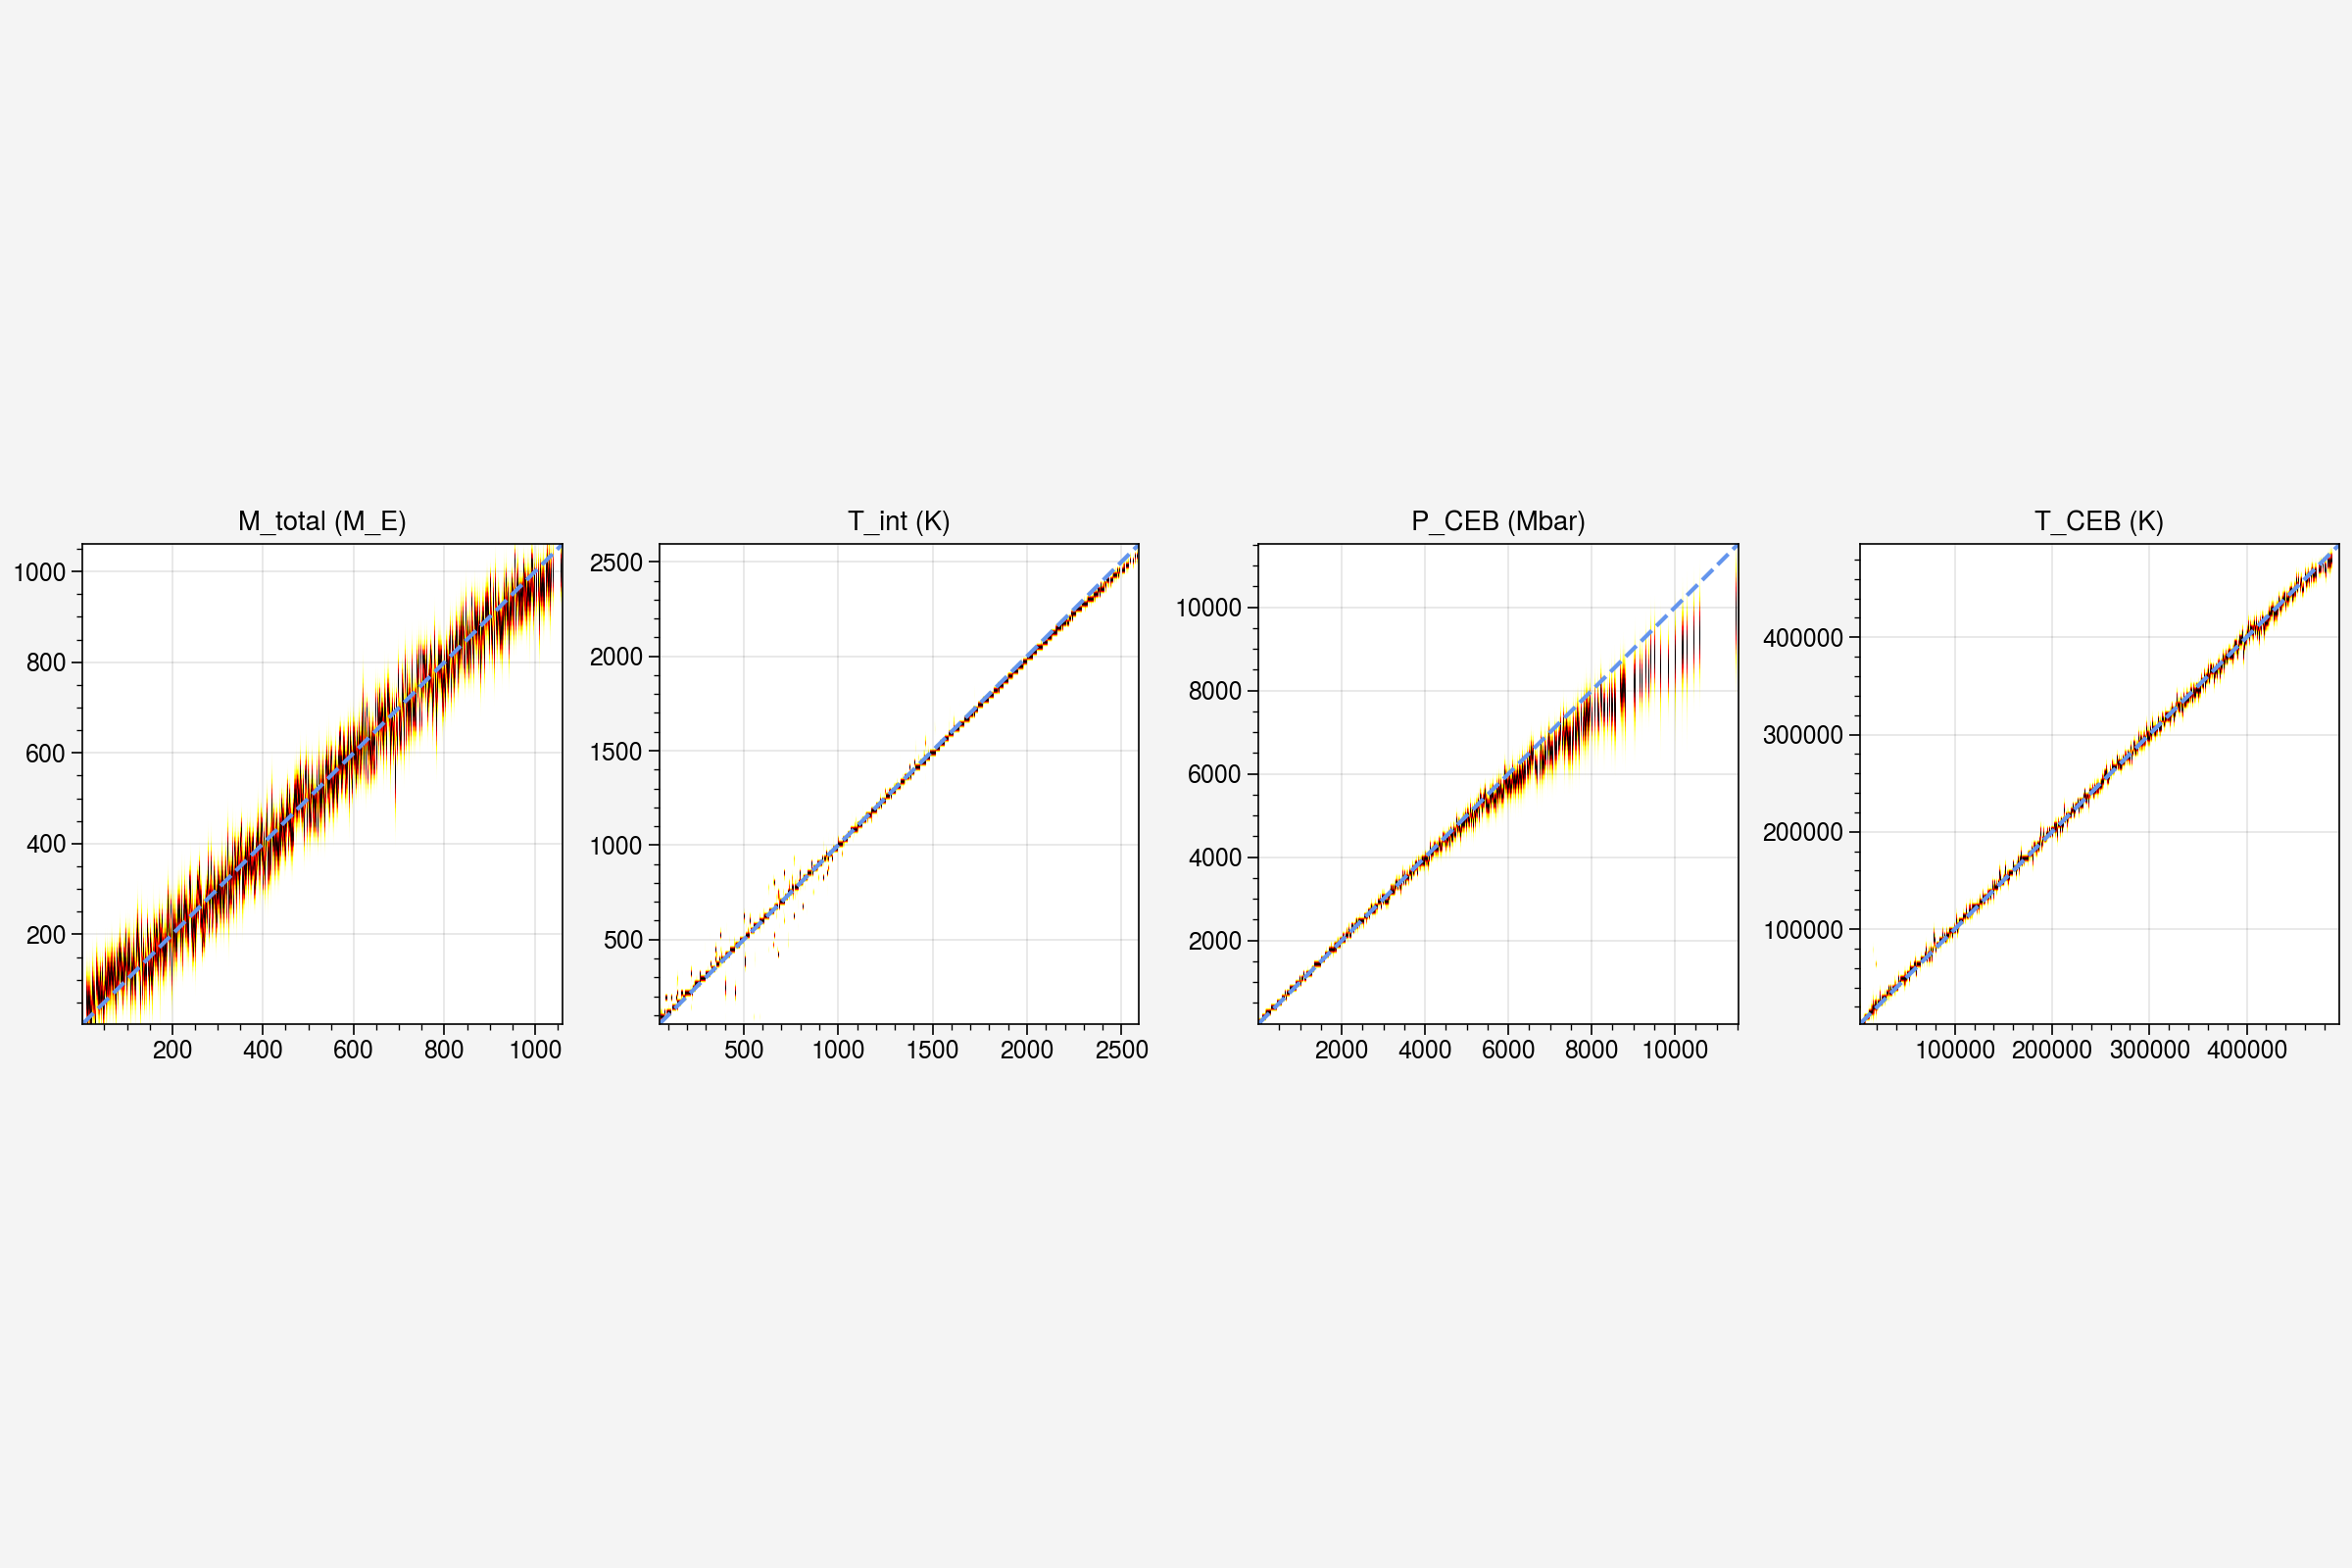

In [14]:
start = time.time()
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
#     figsize=(4,4),
    nrows=1, ncols=4,
    share=False, 
    figsize=(12, 8)
#     tight=True,
)

input_parameters = [
    'Mass (M_J)',
    'Radius (R_E)',
    'T_sur (K)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

xlocators = [
    200, 500, 2000, 100000
]
xminorlocators = [
    0.004, 0.02, 0.02, 0.02, 40, 100, 0.04, 0.004
]

OUTPUT_DIMS = len(output_parameters)

GMM_PDF_scaled = calculate_GMM(pi_np, mu_np, sigma_np)

for o in range(OUTPUT_DIMS):
    y_max = max(test_y_inverse[:, o])
    y_min = min(test_y_inverse[:, o])
    for i in range(0, GMM_PDF_scaled.shape[-1], OUTPUT_DIMS):
        tx, ty = [test_y_inverse[int(i / OUTPUT_DIMS), o], y_min]
        axs[o].imshow(
                GMM_PDF_scaled[:, o + i].reshape(-1, 1),
                cmap=cmap,
                norm=norm,
                origin='lower',
                extent=(tx, tx + 0.0001, ty, y_max)
            )

    axs[o].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[o].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max), title=output_parameters[o], 
        # xlabel=output_parameters[o], 
        xlocator=xlocators[o]
        # ylocator=xlocators[o], yminorlocator=xminorlocators[o]
    )

end = time.time()

In [17]:
fig.save('D:\\PythonProject\\RebuildProject\\Rock\\imgs\\prediction_GasGiantExoplanet_20240117.png')

In [15]:
end - start

68.6850175857544

In [36]:
# 假设对角线的最小值和最大值
gmm_sub = GMM_scaled[:, 0]
test_y_sub = test_y[0, 0]

In [39]:
offset = np.sqrt((gmm_sub - test_y_sub) ** 2)

In [40]:
np.mean(offset)

0.1934626312698771

In [49]:
col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, GMM_scaled.shape[-1], len(output_parameters)):
        test_y_current = test_y[int(i / len(output_parameters)), o]
        GMM_cal = GMM_scaled[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    col_dis.append(dis / len(test_y))

In [50]:
col_dis

[0.3126028332182055,
 0.39397753627944104,
 0.12809810527654258,
 0.35778989743256595]